## Loading training and validation data

We devided the training data to 2 different datasets.
- Training data: The training data will be used to train the model and recalculate the weights 
- Validation data: The validation data will be used to see the network's success on new data.

We use this method in order to prevent over fitting our model. 
The success of our model will be messured by It's preformmance on the Validation data.

* We will set rotation in order to create a larger data set.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

image_size = (256,256)
batch_size = 32

#training_data_dir = r'C:\Users\Karin\Desktop\ML\Data'
#validation_data_dir = r'C:\Users\Karin\Desktop\ML\Test'

# For Google Colab:
from google.colab import drive

drive.mount('/gdrive')

training_data_dir = r'/gdrive/My Drive/train'

train_datagen = ImageDataGenerator(validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data





#train_generator=train_datagen.flow_from_directory(training_data_dir,
#                                                 target_size=image_size,
#                                                 color_mode='rgb',
#                                                 batch_size=batch_size,
#                                                 class_mode='categorical',
#                                                 shuffle=True)

#validation_generator = test_datagen.flow_from_directory(
#                                        validation_data_dir,
#                                         target_size=image_size,
#                                         color_mode='rgb',
#                                        class_mode = "categorical")


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Found 20238 images belonging to 100 classes.
Found 5013 images belonging to 100 classes.


## Display some of the photos

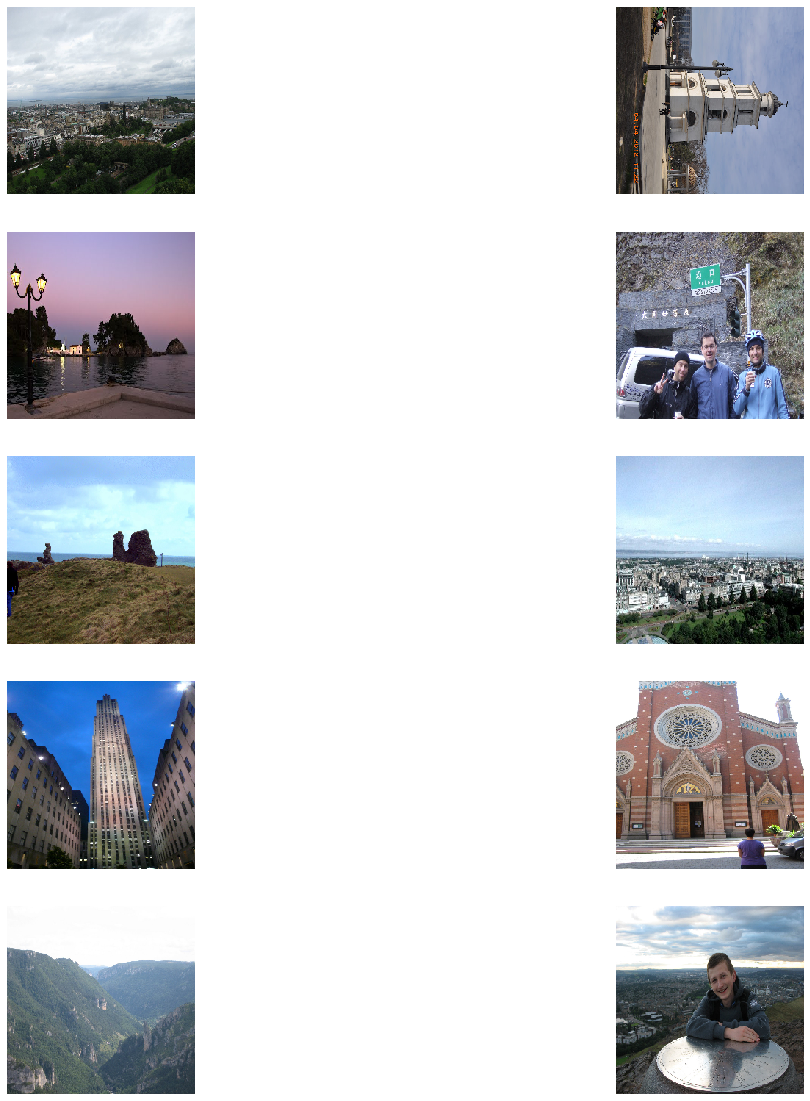

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

# Creating our model

In [0]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

amountOfClasses = 100;

model = Sequential()

# 1 Layer
model.add(Conv2D(64, (3,3), input_shape = (image_size[0], image_size[1], 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.30))

# 2 Layer
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3 Layer
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# 4 Layer
model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 5 Layer
model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.30))

# 6 Layer
model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# 7 Layer
model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 8 Layer
model.add(Conv2D(512, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# 9 Layer
model.add(Conv2D(512, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# 10 Layer
model.add(Conv2D(512, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.30))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))

#output layer
model.add(Dense(amountOfClasses))
model.add(BatchNormalization())
model.add(Activation('softmax'))

#Show the summary
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 254, 254, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 252, 252, 64)      256       
___________________________

## Setting the optimizer

In [0]:
import tensorflow.keras
from tensorflow.keras.optimizers import SGD

model.compile(loss = 'categorical_crossentropy', 
             optimizer= optimizers.SGD(lr=0.001, momentum=0.9),
             metrics=['accuracy'])

## Step Size

In [0]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

632


## Creating Loss and Accuracy history callbacks

In [0]:
class LossAccHisotry(Callback):
    def on_train_begin(self,logs={}):
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss_history.append(logs.get('val_loss'))
        self.val_accuracy_history.append(logs.get('val_acc'))
        self.loss_history.append(logs.get('loss'))
        self.accuracy_history.append(logs.get('acc'))
    
history = LossAccHisotry()## Setting the network saving time periods

# Ignoring images with a bad format

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setting the network saving time periods

In [0]:
import time

networkfileName = r"C:\Users\Karin\Desktop\ML\Final Project\deep_NN_exp1_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Setting early stopping

In [0]:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

## Training the model

In [0]:
NumberOfEpochs = 15;
ValidationSplits = 0.1;
#validation_split=ValidationSplits,

model.fit_generator(generator = train_generator,
                   steps_per_epoch= step_size_train,
                   epochs= NumberOfEpochs,
                   callbacks= [history, checkpoint, early_stop],
                   validation_data= validation_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 10/633 [..............................] - ETA: 3:30:00 - loss: 5.0079 - acc: 0.0188

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


157/157 [==============================] - 3008s 19s/step - loss: 4.0307 - acc: 0.1404

Epoch 00001: val_acc improved from -inf to 0.14043, saving model to C:\Users\Karin\Desktop\ML\Final Project\deep_NN_exp1_1552424263.h5
633/633 [==============================] - 14861s 23s/step - loss: 3.6906 - acc: 0.2128 - val_loss: 4.0307 - val_acc: 0.1404
Epoch 2/5
157/157 [==============================] - 161s 1s/step - loss: 3.3322 - acc: 0.2799

Epoch 00002: val_acc improved from 0.14043 to 0.27987, saving model to C:\Users\Karin\Desktop\ML\Final Project\deep_NN_exp1_1552424263.h5
633/633 [==============================] - 1044s 2s/step - loss: 2.6881 - acc: 0.4295 - val_loss: 3.3322 - val_acc: 0.2799
Epoch 3/5
109/157 [===================>..........] - ETA: 51s - loss: 3.3873 - acc: 0.2623

# Loss and Accuracy graphs

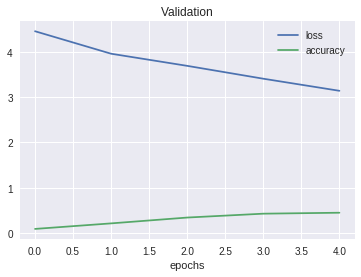

In [0]:
import matplotlib.pyplot as plt
x = range(0, len(history.accuracy_history))
plt.plot(x, history.accuracy_history)
plt.plot(x, history.val_accuracy_history)
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

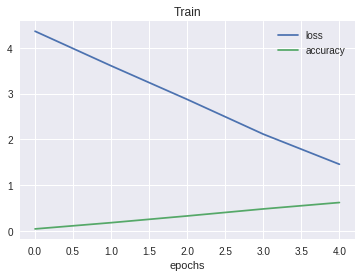

In [0]:
import matplotlib.pyplot as plts
x = range(0, len(history.loss_history))
plt.plot(x, history.loss_history)
plt.plot(x, history.val_loss_history)
plt.xlabel('epochs')
plt.title('Loss')
plt.legend(['loss', 'val_loss'])